In [43]:
'''
Script generate all the models and its subsequent odds ratio plots seen in the manuscript
'''

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
from scipy.stats import mannwhitneyu, wilcoxon
import itertools
from sklearn.preprocessing import StandardScaler
from numpy import inf
import math
from statsmodels.stats.multitest import multipletests
from matplotlib.pyplot import cm
from sklearn.cluster import AgglomerativeClustering


df = pd.read_csv('/Users/tlh4362/Desktop/final_dataset_analysis_11_2.csv')
risk = pd.read_csv('/Users/tlh4362/Desktop/risk_scores.csv')


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,9,19,28,29,52,54,58,91,111) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [44]:
df['sample_date'] = pd.to_datetime(df['sample_date'])

<ipython-input-50-7f38bdfb9440>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp['Race'] = hosp['Race'].replace({'Asian':'Race_Other'}) #low numbers of Asian population, collapse to reduce error
<ipython-input-50-7f38bdfb9440>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wave2['Clade'] = wave2['Clade'].replace({'20I (Alpha, V1)':'Other'})


['Age', 'Clade', 'cases', 'tests', 'seq_case_ratio', 'Race', 'Sex', 'BMI', 'Number_of_Comorbidities', 'clinical_outcome']
(285, 10)
Male      148
Female    137
Name: Sex, dtype: int64
White                        172
Black or African American     53
Race_Other                    29
Race_Declined_Unknown         19
Asian                         12
Name: Race, dtype: int64
20G      160
20A       50
20B       37
20C       27
Other     11
Name: Clade, dtype: int64
Optimization terminated successfully.
         Current function value: 0.321460
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       clinical_outcome   No. Observations:                  285
Model:                          Logit   Df Residuals:                      269
Method:                           MLE   Df Model:                           15
Date:                Thu, 03 Nov 2022   Pseudo R-squ.:                  0.3809
Time:                        14:57:17 

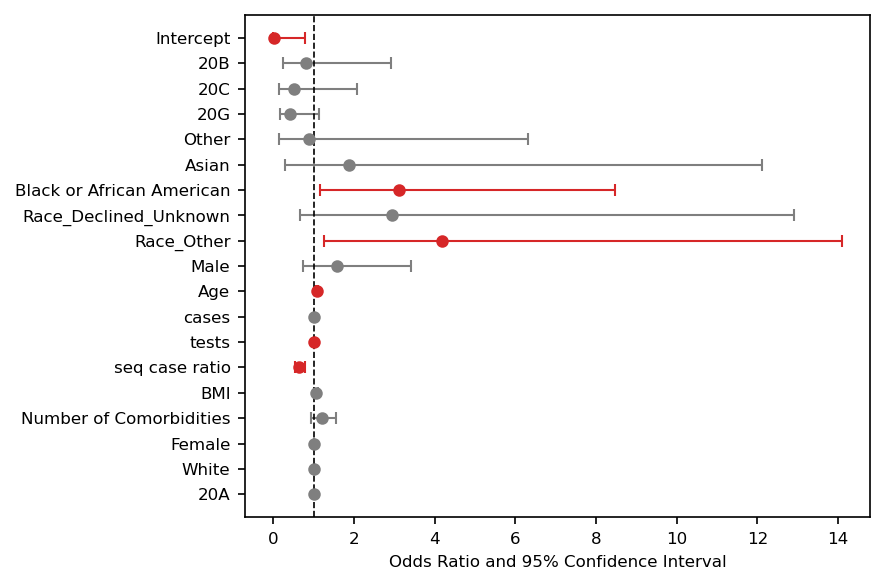

In [50]:
##############################################
#formula used
##############################################

# #fig s3, data = df, overall hosp without clade (all 14k)
# complete_formula = 'clinical_outcome~Age+Sex+C(Race, Treatment(reference = "White"))+Number_of_Comorbidities+BMI+Number_of_vaccination_doses_before_infection'

#fig 3, data = df, overall hosp
# complete_formula = 'clinical_outcome~Age+Clade+Sex+C(Race, Treatment(reference = "White"))+Number_of_Comorbidities+BMI+Number_of_vaccination_doses_before_infection'

# #fig s5, data = hosp, within hosp predicting ICU
# complete_formula = 'ICU~Age+Sex+C(Race, Treatment(reference = "White"))+Number_of_Comorbidities+BMI+Number_of_vaccination_doses_before_infection'

# #fig 5, data = hosp, within hosp predicting ICU with clade included
# complete_formula = 'ICU~Age+Sex+Clade+C(Race, Treatment(reference = "White"))+Number_of_Comorbidities+BMI+Number_of_vaccination_doses_before_infection'

# #fig 6, data = df, overall hosp controlling for epi
complete_formula = 'clinical_outcome~Age+Clade+seq_case_ratio+cases+tests+C(Race,Treatment(reference = "White"))+Sex+BMI+Number_of_Comorbidities+Number_of_vaccination_doses_before_infection'

# fig 6, data = wave2, overall hosp with epi
complete_formula = 'clinical_outcome~Age+Clade+cases+tests+seq_case_ratio+C(Race,Treatment(reference = "White"))+Sex+BMI+Number_of_Comorbidities'


##############################################
#subsets of data
##############################################
hosp = df[df['ca_hosp_admit']==1]

hosp['Race'] = hosp['Race'].replace({'Asian':'Race_Other'}) #low numbers of Asian population, collapse to reduce error


wave2 = df[(df['sample_date'] >= pd.to_datetime('2020-08-01')) & (df['sample_date']<=pd.to_datetime('2021-02-01'))]
wave2['Clade'] = wave2['Clade'].replace({'20I (Alpha, V1)':'Other'})
# wave2 = wave2[wave2['Clade']!= 'Other']
wave2['Race'] = wave2['Race'].replace({'Asian':'Race_Other'})
#                                       'Race_Declined_Unknown':'Race_Other'})

##############################################
#subsets of data
##############################################

data = wave2

##############################################
#subsets of data
##############################################
outcome = complete_formula.split('~')[0]
features = complete_formula.split('~')[1].split('+')

features.append(outcome)
features = ['Race' if 'Race' in x else x for x in features]
print(features)
print(data.loc[:,features].dropna().shape)
print(data.loc[:,features].dropna()['Sex'].value_counts())
print(data.loc[:,features].dropna()['Race'].value_counts())
if 'Clade' in features:
    print(data.loc[:,features].dropna()['Clade'].value_counts()) #.loc[['20A', '20B', '20C', '20G','20I (Alpha, V1)', '21J/I/A (Delta)', '21M/K/L (Omicron)', 'Other']]

     
##############################################
#model used
##############################################
model = smf.logit(complete_formula, data = data)
result = model.fit()
print(result.summary())
# print(result.aic)

##############################################
#preliminary posthoc analysis for multiple pairwise clade comparison
##############################################
if 'Clade' in features:
    pw = result.t_test_pairwise('Clade', method = 'fdr_bh')
    print(pw.result_frame[pw.result_frame['reject-fdr_bh']==True])


##############################################
#odds ratio plot
##############################################

params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['pvalues'] = result.pvalues
odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in result.pvalues]
replace = {}
for x in odds.index:
    if 'T.' in x:
        replace[x] = x.split('T.')[1].split(']')[0]
    else:
        if '_' in x:
            replace[x] = ' '.join(x.split('_'))
        else:
            replace[x] = x
odds = odds.rename(replace)
# odds = odds[odds['97.5%'] < 10]
# odds = odds.drop('Intercept', axis = 0)

odds.at['Female', '2.5%'] = 1
odds.at['Female', '97.5%'] = 1
odds.at['Female', 'Odds Ratio'] = 1
odds.at['Female', 'pvalues'] = 1
odds.at['Female', 'significant?'] = 'not significant'

odds.at['White', '2.5%'] = 1
odds.at['White', '97.5%'] = 1
odds.at['White', 'Odds Ratio'] = 1
odds.at['White', 'pvalues'] = 1
odds.at['White', 'significant?'] = 'not significant'

if 'Clade' in features:
    odds.at['20A', '2.5%'] = 1
    odds.at['20A', '97.5%'] = 1
    odds.at['20A', 'Odds Ratio'] = 1
    odds.at['20A', 'pvalues'] = 1
    odds.at['20A', 'significant?'] = 'not significant'

#'20A','20B','20C','20G', '20I (Alpha, V1)','21J/I/A (Delta)','21M/K/L (Omicron)', 'Other',
#'seq case ratio', 'tests', 'cases'

# odds = odds.loc[['Intercept','20A','20B','20C','20G', 'Other',
#                  'Female', 'Male', 'White', 'Black or African American', 'Race_Other', 'Race_Declined_Unknown',
#                  'Age','Number of Comorbidities','BMI','seq case ratio', 'cases', 'tests'],:]


fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)
for idx, row in odds.iloc[::-1].iterrows():
    ci = [[row['Odds Ratio'] - row[::-1]['2.5%']], [row['97.5%'] - row['Odds Ratio']]]
    if row['significant?'] == 'significant':
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:red", mec="tab:red")
    else:
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:gray', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:gray", mec="tab:gray")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
##############################################
#save figure with correct title
##############################################
# plt.savefig('/Users/tlh4362/Desktop/fig6/fig6b.eps', format = 'eps', bbox_inches = 'tight')
plt.show()
